In [1]:
import pickle
import pandas as pd
from result.compare import min_tpr_from_exceedance, min_tpr_from_target
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

save = False
# label parameters
day = 24
month = 30 * day
lq = [0.01, 0.025, 0.05, 0.1]
window = [day, 4*month, 6*month]

In [2]:
# label definition
def labelQuantile(close,
                  lq=0.1,
                  uq=0.9,
                  lookfront=1,
                  window=30,
                  threshold=None,
                  log=False,
                  fee=0,
                  binary=False):
    hist_returns = np.zeros(len(close), dtype=float)

    if log:
        hist_returns[1:] = np.log(close[1:] / close[0:-1])
    else:
        hist_returns[1:] = close[1:] / close[0:-1] - 1

    labels = np.zeros(len(close), dtype=int)
    returns = np.zeros(len(close), dtype=float)

    lower_q = np.zeros(len(close), dtype=float)
    upper_q = np.zeros(len(close), dtype=float)

    for t in range(window, len(close) - lookfront):
        data_w = hist_returns[t - window: t]  # select past window

        if threshold is not None:
            losses = data_w[data_w < -threshold]
            gains = data_w[data_w >= threshold]
            lower_q_t = np.quantile(losses, lq)
            upper_q_t = np.quantile(gains, uq)
        else:
            lower_q_t = np.quantile(data_w, lq)
            upper_q_t = np.quantile(data_w, uq)

        # Look into future returns
        for i in range(1, lookfront + 1):
            # label = 1 if we hit the upper band
            # label = 2 if we hit the lower band
            # else label = 0
            ratio = hist_returns[t + i]
            if ratio <= lower_q_t:
                if binary:
                    labels[t] = 1
                else:
                    labels[t] = 2
                break
            elif ratio >= upper_q_t:
                labels[t] = 1
                break

        returns[t] = hist_returns[t + i]  # p_t+lookfront/p_t - 1
        lower_q[t] = lower_q_t
        upper_q[t] = upper_q_t

    quantiles = np.concatenate([lower_q.reshape(-1, 1),
                                upper_q.reshape(-1, 1)],
                               axis=1)

    quantiles[:window, 0] = lower_q[window]
    quantiles[:window, 1] = upper_q[window]
    returns[:window] = hist_returns[:window]

    return labels, returns, quantiles

In [3]:
# load data
data = pd.read_csv('./data/btc_1H_20160101_20200217.csv', index_col = 0)
data.index = pd.to_datetime(data.index)
data = data.loc[:'2019-01-01']

# Get labels

In [4]:
dfdata = {}
close = data.close

for w in window:
    for q in lq:
        print(w, q)
        labels, returns, quantiles = labelQuantile(data.close.values,
                                                   lq=q,
                                                   uq=1-q,
                                                   lookfront=1,
                                                   window=w,
                                                   log=True)
        
        dfdata[w, q] = pd.DataFrame(data.close.values, columns = ['close'], index = data.index)
        dfdata[w, q]['returns'] = returns

        dfdata[w, q]['label'] = labels

        dfdata[w, q]['lq'] = quantiles[:,0]
        dfdata[w, q]['uq'] = quantiles[:,1]

24 0.01
24 0.025
24 0.05
24 0.1
2880 0.01
2880 0.025
2880 0.05
2880 0.1
4320 0.01
4320 0.025
4320 0.05
4320 0.1


## Figure 1: Hourly btc losses and $TVaR_t^{0.01, w}$ for different window size, w = 24 (one day), w = 2880 (four months), w = 4320 (six months)

/Users/brunospilak/Documents/HU/bruno_phd/MLvsGARCH/mlvsgarch_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


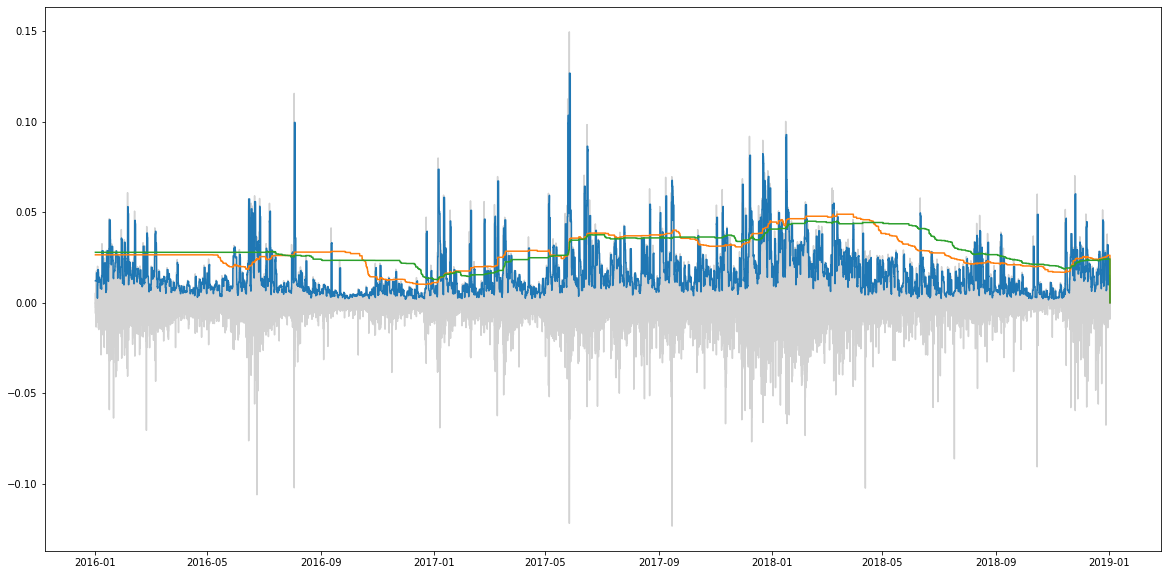

In [5]:
plt.figure(figsize = (20,10))
plt.plot(- dfdata[(24, 0.01)]['returns'], color = 'lightgrey')
plt.plot(- dfdata[(24, 0.01)]['lq'])
plt.plot(- dfdata[(2880, 0.01)]['lq'])
plt.plot(- dfdata[(4320, 0.01)]['lq'])
if save:
    plt.savefig('tvar_0.01_w.png', bbox_inches='tight')

# Get exceedance for each label

In [6]:
exceedance = {}
for w in window:
    for q in lq:
        temp = dfdata[w, q].iloc[window[-1]:-1,:]
        exceedance[w, q] = sum(temp['label'])/len(temp)
exceedance

{(24, 0.01): 0.1331394556277548,
 (24, 0.025): 0.1623574317262689,
 (24, 0.05): 0.24583087199527423,
 (24, 0.1): 0.37256327532148864,
 (2880, 0.01): 0.03485254691689008,
 (2880, 0.025): 0.08360976053074022,
 (2880, 0.05): 0.1637660744308629,
 (2880, 0.1): 0.3100831553596583,
 (4320, 0.01): 0.034716226655155176,
 (4320, 0.025): 0.08438224201390467,
 (4320, 0.05): 0.1649020766119871,
 (4320, 0.1): 0.30762939064843003}

# Table 2: Expected exceedance and corresponding minimum TPR for different VaR estimators

In [7]:
table = pd.DataFrame(index = pd.MultiIndex.from_product([lq, window], names = ['alpha', 'window']),
                     columns = ['exceedance', 'tpr'])
table['exceedance'] = [exceedance[qw[1], qw[0]] for qw in list(table.index) ]
table['tpr'] = [min_tpr_from_target(dfdata[qw[1], qw[0]].iloc[window[-1]:-1,:]['label'], qw[0]) for qw in list(table.index)]
table = (table * 100).round(0).astype(int)
if save:
    table.to_csv('exceedance_tpr_vs_w_alpha.csv')
table

exceedance  tpr
alpha window                 
0.010 24              13   77
      2880             3   18
      4320             3   18
0.025 24              16   53
      2880             8   17
      4320             8   17
0.050 24              25   38
      2880            16    8
      4320            16    9
0.100 24              37   18
      2880            31    4
      4320            31    3

## Figure 4: Expected exceedance and corresponding minimum TPR for significance levels 0.01, 0.025, 0.05, 0.1

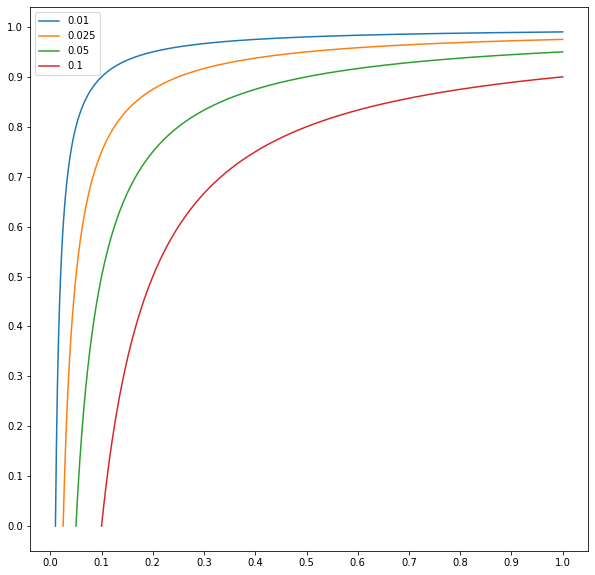

In [8]:
plt.figure(figsize=(10,10))
for alpha in lq:
    alpha_bar = np.linspace(alpha, 1, 1000)
    min_tpr = np.array([[a, min_tpr_from_exceedance(a, alpha)] for a in alpha_bar])
    plt.plot(min_tpr[:,0], min_tpr[:,1], label = alpha)
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.legend()
if save:
    plt.savefig('min_tpr_exceedance_alpha.png', bbox_inches='tight')